In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('gpu')

In [2]:
import arviz as az
from leaguedata.plot import plot_history, plot_compare_plotly
from leaguedata.model import generate_coinflip_history, generate_nasty_loser_q, generate_obvious_loser_q

2024-06-03 22:40:30.106296: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Obvious LoserQ

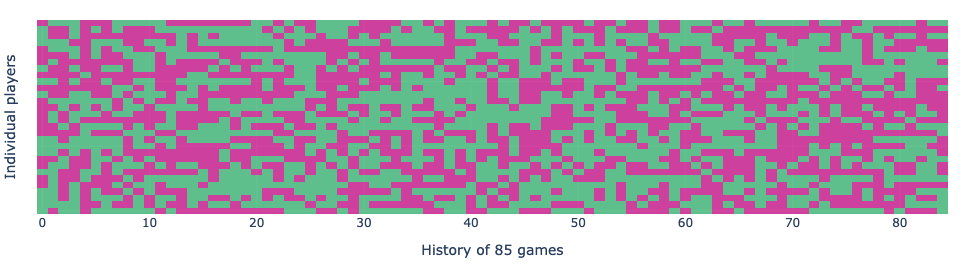

In [3]:
mock_history = generate_obvious_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history, save_to='docs/loserQ/assets/validation_obvious.json');

In [4]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_obvious_loser_q(number_of_players=100, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history, num_chains=4)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

sample: 100%|██████████| 2000/2000 [00:12<00:00, 158.32it/s]


rank     elpd_loo      p_loo   elpd_diff        weight         se  \
4 games     0 -5745.870488  15.301600    0.000000  9.478132e-01  18.692770   
5 games     1 -5757.307052  31.619745   11.436564  0.000000e+00  18.984377   
6 games     2 -5772.107180  63.158937   26.236692  0.000000e+00  20.448783   
3 games     3 -5780.223802   8.692504   34.353314  2.757236e-02  17.256929   
2 games     4 -5809.011716   4.995586   63.141228  3.090141e-13  15.245442   
1 games     5 -5847.625720   2.990364  101.755232  2.461447e-02   9.705114   
0 games     6 -5893.480415   2.487613  147.609927  3.552714e-13   0.367364   

               dse  warning scale  
4 games   0.000000    False   log  
5 games   3.708089    False   log  
6 games   7.338320    False   log  
3 games   8.939629    False   log  
2 games  11.373259    False   log  
1 games  14.412931    False   log  
0 games  18.735779    False   log

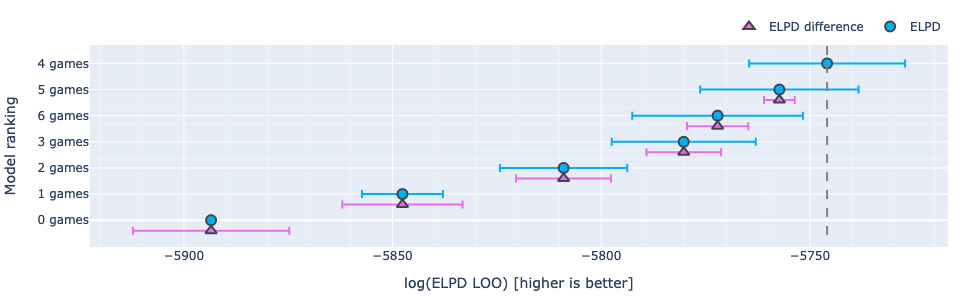

In [5]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_obvious_compare.json');

In [7]:
best_id = dict_of_id['4 games']

/opt/mamba/lib/python3.12/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




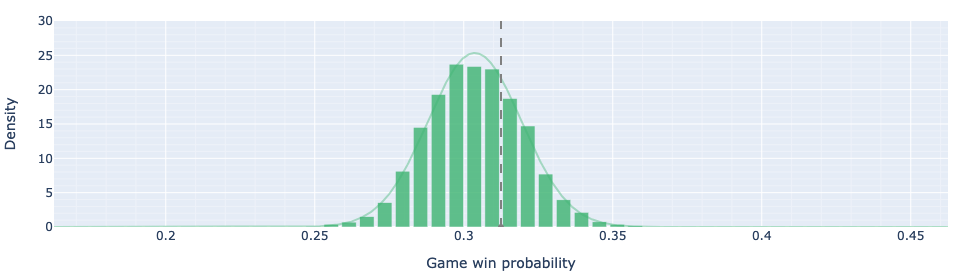

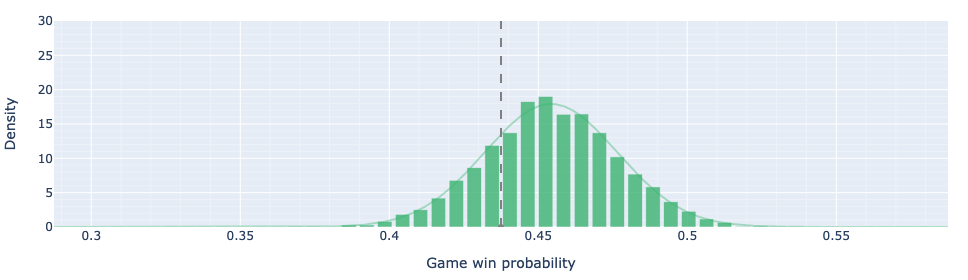

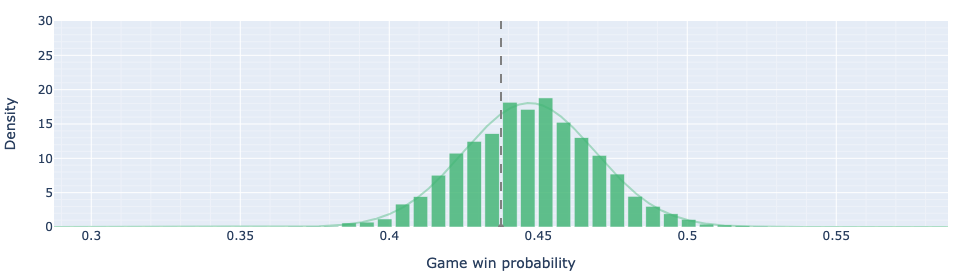

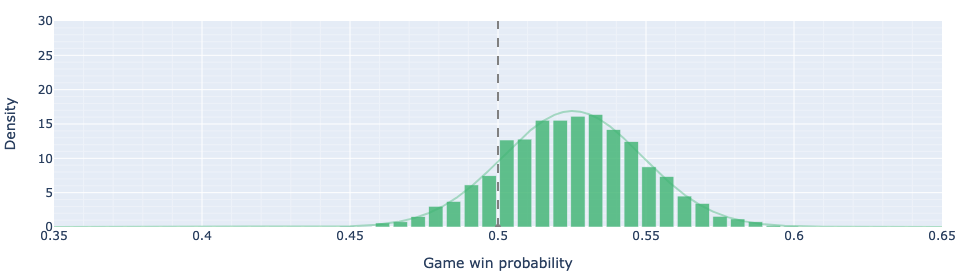

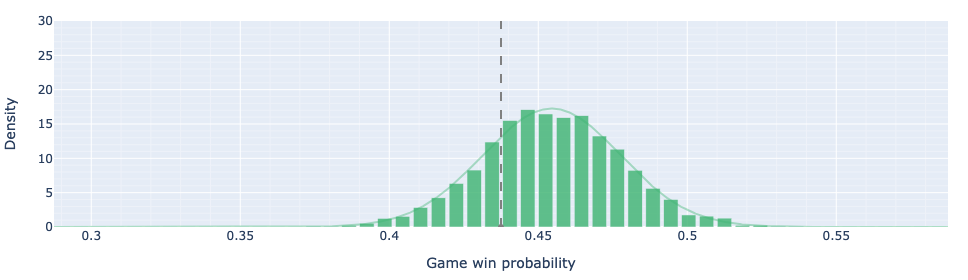

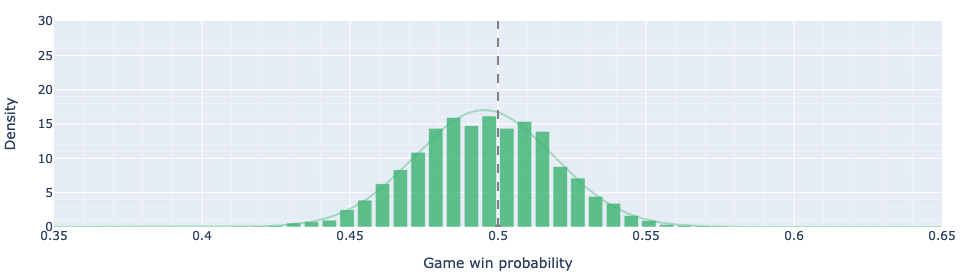

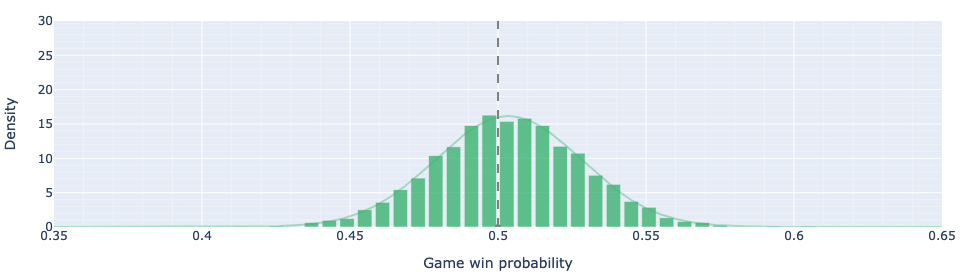

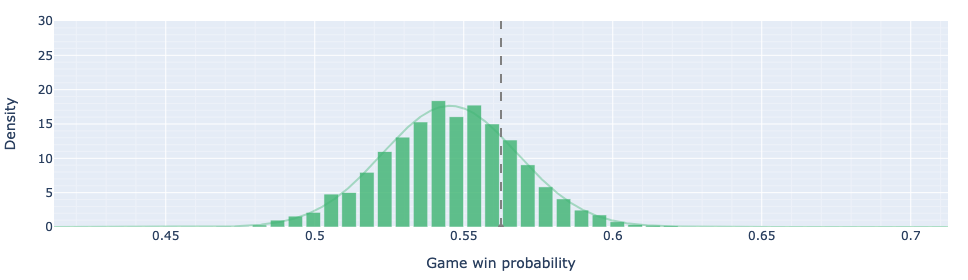

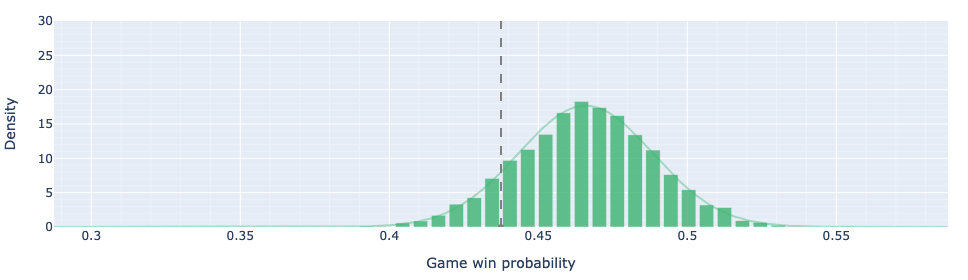

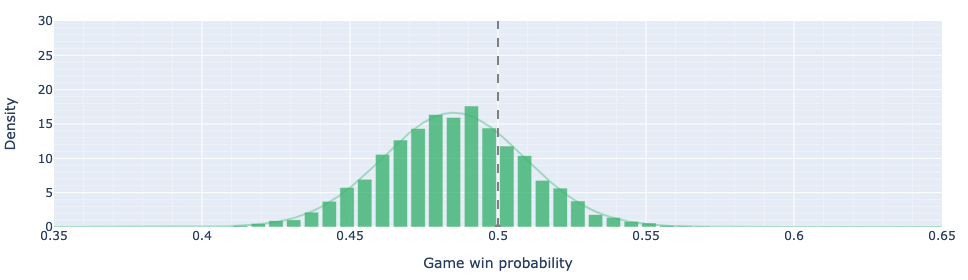

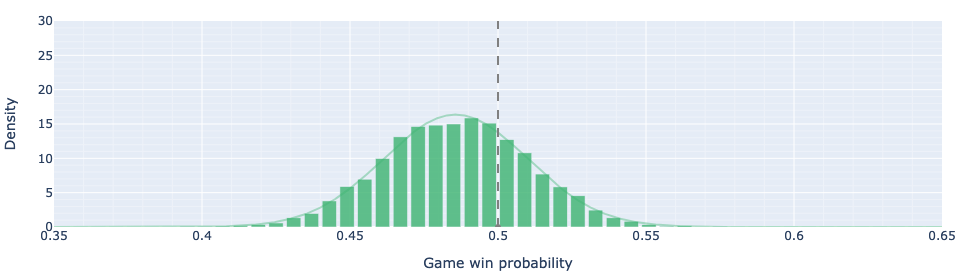

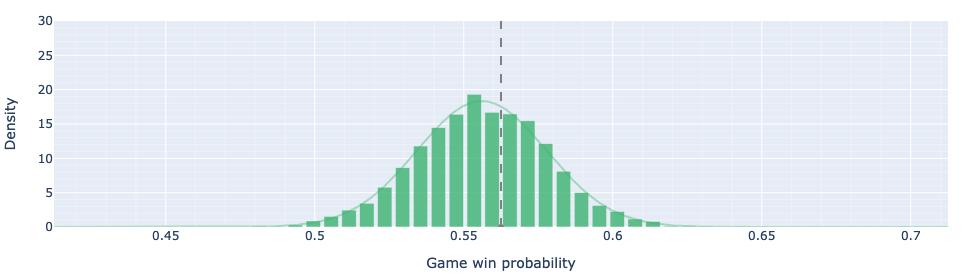

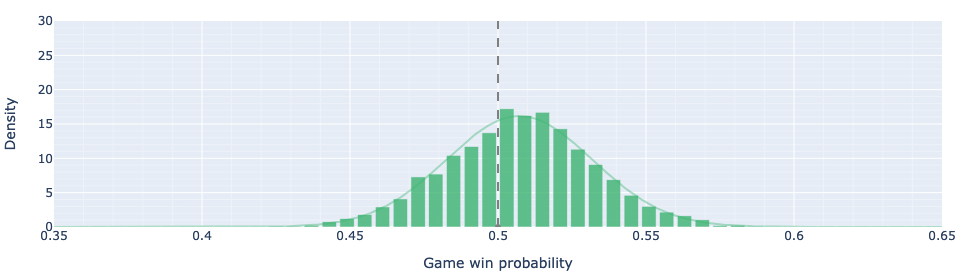

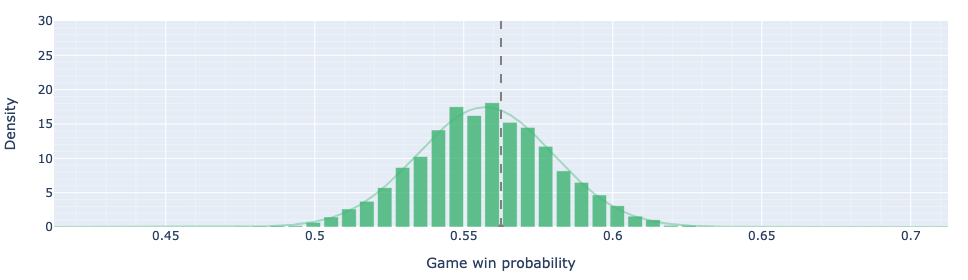

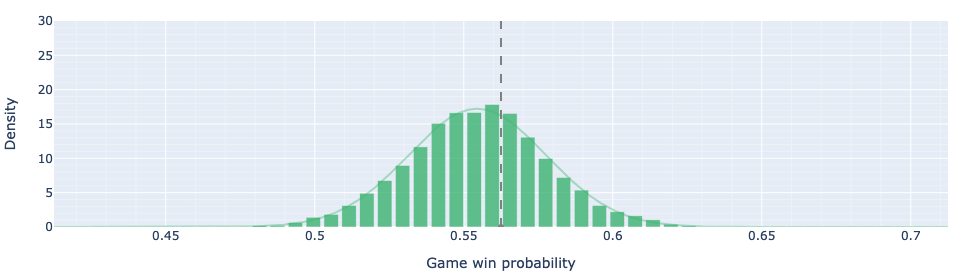

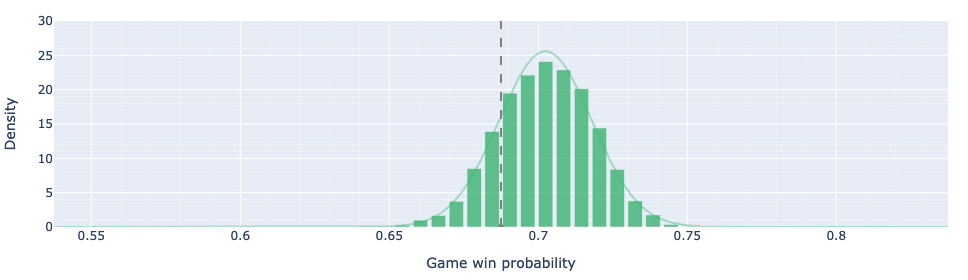

In [8]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import numpy as np
import pandas as pd 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from leaguedata.inference import DTMCModel
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4 games']
markov_util = DTMCModel(4)
samples = np.asarray(az.extract(best_id).proba)

probs = jnp.empty((2 ** 4))
importance = 0.5

probs_keys = {
    0.: 0.5 - 0.375 * importance,
    0.25: 0.5 - 0.125 * importance,
    0.5: 0.5,
    0.75: 0.5 + 0.125 * importance,
    1.: 0.5 + 0.375 * importance
}

for i, state in enumerate(markov_util.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state) / 4])

probs = np.asarray(probs)
results = np.asarray(az.extract(best_id).proba)
# List of data and colors
titles = [''.join(["W" if win else "L" for win in state]) + '-> W' for state in markov_util.get_states()]
colors = ['rgba(60, 179, 113, 0.8)']*16  #'rgba(199, 21, 133, 0.8)'
colors_density = ['rgba(60, 179, 113, 0.4)']*16   #'rgba(199, 21, 133, 0.4)'

for i, (data, true_proba, title, color, color_density) in enumerate(zip(results, probs, titles, colors, colors_density)):


    x_min, x_max = max(true_proba - 0.15, 0), min(true_proba + 0.15, 1)
    fig = go.Figure()#make_subplots(rows=2, cols=2, subplot_titles=titles, shared_xaxes='all', shared_yaxes='all',)
    # Compute histogram
    hist = np.histogram(data, bins=50, range=(x_min, x_max), density=True)
    bins = hist[1]
    bin_centers = (bins[:-1] + bins[1:]) / 2

    data = np.asarray(data)
    
    # Fit a gaussian
    mu, sigma = norm.fit(data)
    pdf = norm.pdf(np.linspace(x_min, x_max, 1000), mu, sigma)

    # Create histogram trace
    hist_trace = go.Bar(x=bin_centers, y=hist[0], showlegend=False, marker_color=color, name=f'Hist {i+1}')
    
    # Create gaussian fit trace
    fit_trace = go.Scatter(x=np.linspace(x_min, x_max, 1000), y=pdf, mode='lines', line=dict(color=color_density),
                           text=[f'Mean: {mu:.2f}<br>Sigma: {sigma:.2f}']*len(bin_centers),
                           hoverinfo='text+x+y')

    ref_trace = go.Line(
        x=[true_proba, true_proba], 
        y=[0, 400], 
        line=dict(color="grey", width=2, dash="dash")
    )
    
    # Add traces to the subplot
    fig.add_trace(hist_trace)#, row=row, col=col)
    fig.add_trace(fit_trace)#, row=row, col=col)
    fig.add_trace(ref_trace)#, row=row, col=col)

    
    fig.update_xaxes(range=[x_min, x_max], title='Game win probability', 
        showgrid=True, minor=dict(showgrid=True))
    fig.update_yaxes(range=[0., 30.], title='Density', 
        showgrid=True, minor=dict(showgrid=True))
    
    # Update layout
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        #title_text=titles[i], title_x=0.5, title_y=0.95,
        height=280, width=320, showlegend=False,
    )
    
    # Show plot
    fig.show()
    
    with open(f'docs/loserQ/assets/validation_transition_probas_{i}.json', "w") as f:
        f.write(fig.to_json())

# Nasty LoserQ

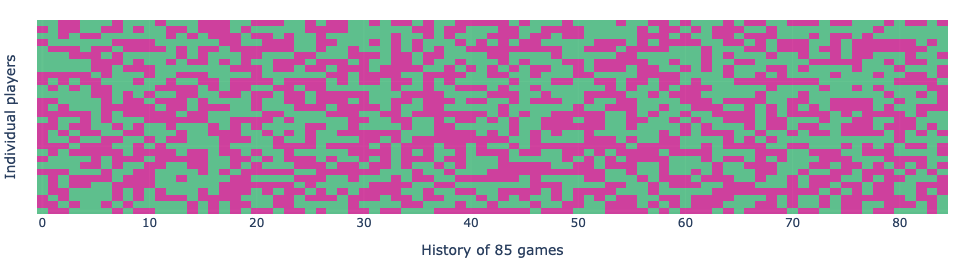

In [12]:
mock_history = generate_nasty_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history, save_to='docs/loserQ/assets/validation_nasty.json');

In [10]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_nasty_loser_q(number_of_players=100, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

sample: 100%|██████████| 2000/2000 [00:15<00:00, 128.23it/s]


rank     elpd_loo      p_loo  elpd_diff        weight        se  \
4 games     0 -5885.370526  16.037353   0.000000  6.185658e-01  6.575544   
2 games     1 -5889.429556   4.187140   4.059030  1.818193e-01  3.994272   
1 games     2 -5891.283509   2.208317   5.912983  0.000000e+00  2.225966   
3 games     3 -5891.754995   8.308432   6.384469  0.000000e+00  4.730209   
0 games     4 -5892.643881   1.303634   7.273355  1.996149e-01  0.827630   
5 games     5 -5895.572151  32.467391  10.201625  3.398236e-14  7.705682   
6 games     6 -5912.314017  63.719064  26.943492  3.358203e-12  9.289898   

              dse  warning scale  
4 games  0.000000    False   log  
2 games  5.566346    False   log  
1 games  5.931923    False   log  
3 games  5.510937    False   log  
0 games  6.573983    False   log  
5 games  3.899474    False   log  
6 games  6.513195    False   log

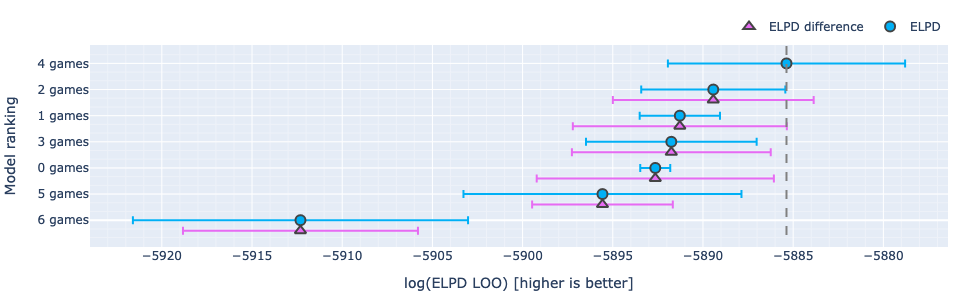

In [11]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_nasty_compare.json');